Before you start you probably need some packages again to follow along the tutorial and the excercise. In this tutorial we will use Keras, an Application Programming Interface(API) built on the Tensorflow-library, a powerful library used mainly for neural networks. Run the cell below or run in the terminal to install it in an environment of your choice.

In [ ]:
!conda install tensorflow
!conda install keras

In [12]:
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC
from keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import numpy as np

# Convolutional Neural Networks Tutorial

### The MNIST numbers dataset

The MNIST-numbers dataset is a good place to start with CNNs as it's easy to judge the correctness of the predictions for us. The dataset consists of 28x28 pixel images of handwritten numbers in greyscale values. It's split in 60k images for training and 10k images for testing.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(60000, 28, 28), y=(60000,)


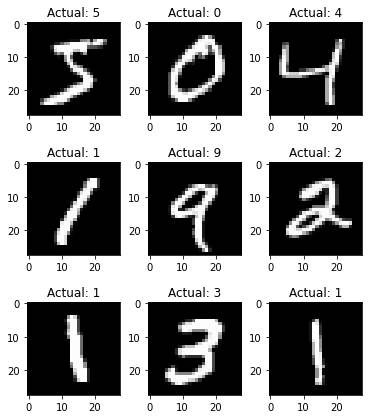

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# confirm dataset size and shape
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test: X={X_train.shape}, y={y_train.shape}")
# plot first 9 images
fig, axs = plt.subplots(3, 3)
plt.subplots_adjust(top=1.5,wspace=0.3)
for i in range(3):
    for j in range(3):
        ax = axs[i,j]
        ax.imshow(X_train[i*3+j], cmap=plt.get_cmap('gray'))
        ax.set_title(f"Actual: {y_train[i*3+j]}")
   
plt.show()

### Data manipulation

Training a neural network can be time-intensive. To reduce the amount of weight updates needed until convergence it's useful to scale the data. We will use a MinMax-Scaler to to bring the greyscale-values(ranging from 0 to 255) to values between 0 and 1. MinMax-Scaler will try to scale each column of the inputs, so we will flatten the data and restore the original shape afterwards(* before a tuple unpacks the values) and add an additional dimension for the color-channel, which in our case is 1 as we only have greyscale-data.

Also we want to predict the 10 classes of numbers, but only have 1 single output for each picture so far. To get 10 outputs we will one-hot-encode our y-values. This means every value is zero, but the class that the value belongs to. So if the picture shows a 4, then the fifth value in the output-array will be 1 and the remaining nine values will be zero, as 4 is the fifth integer counting the 0.

In [13]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape((-1,1))).reshape((*X_train.shape,1))
X_test_scaled = scaler.transform(X_test.reshape((-1,1))).reshape(*(X_test.shape),1)
print("Unscaled max:", np.max(X_train))
print("Unscaled min:", np.min(X_train))
print("Scaled max:", np.max(X_train_scaled))
print("Scaled min:", np.min(X_train_scaled))

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
print("Output-shape before transformation:", y_train.shape)
print("Output-shape after transformation:", y_train_categorical.shape)
print("Example outputs:", y_train[0], y_train_categorical[0])

Unscaled max: 255
Unscaled min: 0
Scaled max: 1.0
Scaled min: 0.0
Output-shape before transformation: (60000,)
Output-shape after transformation: (60000, 10)
Example outputs: 5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Creating the model

Convolutional neural networks mainly depend on two special layers: the [Convolutional Layer](https://1.cms.s81c.com/sites/default/files/2021-01-06/ICLH_Diagram_Batch_02_17A-ConvolutionalNeuralNetworks-WHITEBG.png) and the [Pooling Layer](https://de.wikipedia.org/wiki/Convolutional_Neural_Network#/media/Datei:Max_pooling.png).

In convolutional layers a $ n\cdot m$-shaped filter is defined. The output is the sum of the element-wise products of input and filter. After each calculation the filte is moved to the right or down with a certain stride length(Schrittweite). To avoid pixel-cutoffs by too wide filters at the end of a line, it's possible to pad your data. While training, the entries in the filter will be changed.

In pooling layers a $ n\cdot m$-section of the input is considered. For different types of pooling layers different operations may be applied to these sections. A common pooling layer is max-pooling, where only the maximal number of the section will be passed to the output.

First will use a single convolutional layer, which applies 5 filtes of 3x3-shape, which will move in 3x3-strides(3 steps to the right and 3 steps down, if end of the line is reached), with a relu-activation-function on the 28x28-pixel images.

Then we will pool the results with a MaxPooling-layer of shape 2x2 and 1x1-strides(default-setting).

The resulting matrix(whatever shape it was by now) will be flattened into a single array and fed into a small fully-connected neural network with a 100-neuron-layer and a 10-neuron-output-layer. As we have to deal with a classification problem here, the final layer has to have the same amount of neuron as we have classification-classes. Also we will use a softmax-activation-function in the end, so that the result can be interpreted as probabilities.

In [15]:
model = Sequential(name="Conv_Net")
model.add(layers.InputLayer(input_shape=(28, 28, 1)))
model.add(layers.Conv2D(filters=5, kernel_size=(3, 3), strides=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "Conv_Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 9, 5)           50        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 5)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               8100      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 9,160
Trainable params: 9,160
Non-trainable params: 0
_________________________________________________________________


Now we have to add the loss-function(Mean-Squared-Error for regression or Cross-Entropy Loss for classification) and the optimizer that we like prefer(e.g. Gradient Descent, Stochastic Gradient Descent(SGD), Adaptive Moment Estimation(Adam)) during the compilation of the model. We can also add the metrics, that we want to track during the training.

The optimizer also needs a learning-rate, by which the gradients are multiplied.

In [16]:
my_optimizer = Adam(learning_rate=0.0005)
my_loss = CategoricalCrossentropy()
my_metrics = [CategoricalAccuracy(name='Accuracy'), AUC(name='Area_under_Curve')]

model.compile(
    loss = my_loss,
    optimizer = my_optimizer,
    metrics = my_metrics
    )

### Training the model

Now we can start the training with forward pass, result evaluation and finally the backward pass to update the weights. All of this is done in a single function in tensorflow: fit. Fit will return a History-object, from which the results of the training for each epoch can be accessed. You must also supply the function with inputs and outputs. The amount of epochs can be specified. The batch_size determines how many examples are seen at once, which reduces the required runs per epoch.
If you want to, you can split an additional portion from the training_data for validation and shuffle the data after each epoch. To suppress the output of the training, set verbose to 0.

In [17]:
history = model.fit(
                    x=X_train_scaled,
                    y=y_train_categorical,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.1,
                    shuffle=True,
                    verbose=1)

Epoch 1/20
422/422 [==============================] - 3s 7ms/step - loss: 1.1077 - Accuracy: 0.6795 - Area_under_Curve: 0.9412 - val_loss: 0.5722 - val_Accuracy: 0.8227 - val_Area_under_Curve: 0.9827
Epoch 2/20
422/422 [==============================] - 2s 6ms/step - loss: 0.5448 - Accuracy: 0.8295 - Area_under_Curve: 0.9825 - val_loss: 0.4180 - val_Accuracy: 0.8688 - val_Area_under_Curve: 0.9891
Epoch 3/20
422/422 [==============================] - 2s 5ms/step - loss: 0.4388 - Accuracy: 0.8610 - Area_under_Curve: 0.9877 - val_loss: 0.3514 - val_Accuracy: 0.8870 - val_Area_under_Curve: 0.9915
Epoch 4/20
422/422 [==============================] - 2s 5ms/step - loss: 0.3796 - Accuracy: 0.8792 - Area_under_Curve: 0.9903 - val_loss: 0.3139 - val_Accuracy: 0.9000 - val_Area_under_Curve: 0.9927
Epoch 5/20
422/422 [==============================] - 2s 4ms/step - loss: 0.3401 - Accuracy: 0.8919 - Area_under_Curve: 0.9918 - val_loss: 0.2840 - val_Accuracy: 0.9107 - val_Area_under_Curve: 0.9940


### Evaluating the model

Lastly you should evaluate, how the training progressed and how precise the model classifies the handwritten digits. 

Let's have a look at the training. Is the model converged or do we need more epochs?

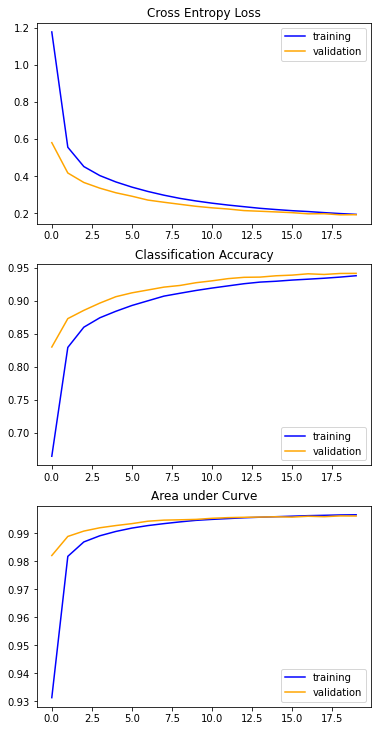

In [8]:
plt.subplot(3, 1, 1)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='training')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.subplot(3, 1, 2)
plt.title('Classification Accuracy')
plt.plot(history.history['Accuracy'], color='blue', label='training')
plt.plot(history.history['val_Accuracy'], color='orange', label='validation')
plt.legend()
plt.subplot(3, 1, 3)
plt.title('Area under Curve')
plt.plot(history.history['Area_under_Curve'], color='blue', label='training')
plt.plot(history.history['val_Area_under_Curve'], color='orange', label='validation')
plt.legend()
plt.subplots_adjust(top=2.5)
plt.show()

Let's move on to the predictions of the test-set. We can calculate our requested metrics of the model with `evaluate`. The probabilities can be calculated with model.predict, but we will need the maximum value of the probabilities. In this special case, this will actually be the prediction of the datapoint, but in others cases you might still have to use the index of the maximum probability as the index of a list of your classes complete the prediction. So we will go through these motions here as well. We can use this information to plot the confusion-matrix.

Loss:  0.20
Accuracy:  0.94
AUC:  1.00
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.96      0.94      1032
           3       0.93      0.91      0.92      1010
           4       0.97      0.94      0.95       982
           5       0.90      0.93      0.91       892
           6       0.96      0.96      0.96       958
           7       0.93      0.93      0.93      1028
           8       0.89      0.88      0.88       974
           9       0.92      0.89      0.90      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



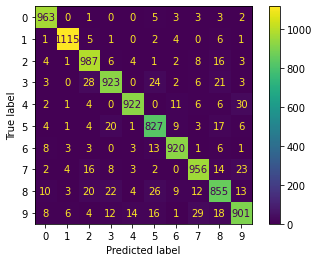

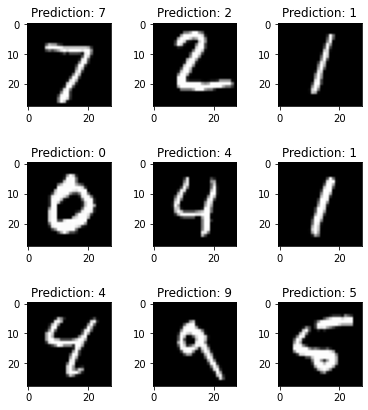

In [11]:
loss, acc, auc = model.evaluate(X_test_scaled, y_test_categorical, verbose=0)
print(f"Loss: {loss: .2f}")
print(f"Accuracy: {acc: .2f}")
print(f"AUC: {auc: .2f}")

classes = list(range(10))
probabilities = model.predict(X_test_scaled, verbose=0)
max_probability = np.argmax(probabilities, axis=1)
class_prediction = [classes[max_probability_index] for max_probability_index in max_probability]

print(classification_report(y_test, class_prediction))

cm = confusion_matrix(y_test, class_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

fig, axs = plt.subplots(3, 3)
plt.subplots_adjust(top=1.5,wspace=0.5)
for i in range(3):
    for j in range(3):
        ax = axs[i,j]
        ax.imshow(X_test[i*3+j], cmap=plt.get_cmap('gray'))
        ax.set_title(f"Prediction: {class_prediction[i*3+j]}")
